<a href="https://colab.research.google.com/github/ashishkumarsaklani/AIML/blob/main/Clustering.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

#importing libraries

In [82]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.impute import KNNImputer
from sklearn.preprocessing import LabelEncoder


#from sklearn import linear_model
#from sklearn.linear_model import LinearRegression,SGDRegressor,ElasticNet,LogisticRegression
#from sklearn.model_selection import train_test_split ,KFold, GridSearchCV
#from sklearn.metrics import mean_squared_error, r2_score,accuracy_score,precision_score,recall_score, confusion_matrix,f1_score,roc_auc_score
#from sklearn.preprocessing import StandardScaler,MinMaxScaler,PolynomialFeatures
#from sklearn.ensemble import RandomForestClassifier
#from sklearn.pipeline import Pipeline



import re

#Custom Class

In [83]:

class CustomEncoder:
    def __init__(self):
        self.encoding_dict = {}  # Dictionary to store encoding mappings
        self.counter = 1  # Counter to assign integer encoding values

    def fit_transform(self, series):
        encoded_list = []  # List to store encoded values

        for item in series:
            if pd.isna(item):
                encoded_list.append(item)
            elif item not in self.encoding_dict:
                self.encoding_dict[item] = self.counter
                self.counter += 1
                encoded_list.append(self.encoding_dict[item])
            else:
                encoded_list.append(self.encoding_dict[item])

        return encoded_list, self.encoding_dict

    def inverse_transform(self, encoded_list, encoding_dict):
        reverse_dict = {v: k for k, v in encoding_dict.items()}  # Reverse the dictionary for decoding
        return [reverse_dict[encoded_value] if encoded_value in reverse_dict else encoded_value for encoded_value in encoded_list]

# Example usage:
encoder = CustomEncoder()
input_series = ['a', 'b', 'b', 'c', 'a', np.nan]
encoded_list, encoding_dict = encoder.fit_transform(input_series)
print("Encoded List:", encoded_list)
print("Encoding Dictionary:", encoding_dict)

decoded_list = encoder.inverse_transform(encoded_list, encoding_dict)
print("Decoded List:", decoded_list)

Encoded List: [1, 2, 2, 3, 1, nan]
Encoding Dictionary: {'a': 1, 'b': 2, 'c': 3}
Decoded List: ['a', 'b', 'b', 'c', 'a', nan]


In [84]:
class IQROutlierDetector:

  def __init__(self, data, column_name):

    self.data = data
    self.column_name = column_name

  def detect_outliers(self):


    if not pd.api.types.is_numeric_dtype(self.data[self.column_name]):
      #print(f"Warning: Column '{self.column_name}' is not numerical. Skipping outlier detection.")
      return None  # Indicate non-numerical column

    q1 = self.data[self.column_name].quantile(0.25)
    q3 = self.data[self.column_name].quantile(0.75)
    iqr = q3 - q1
    lower_bound = q1 - 1.5 * iqr
    upper_bound = q3 + 1.5 * iqr
    outliers = self.data[(self.data[self.column_name] < lower_bound) | (self.data[self.column_name] > upper_bound)].index.tolist()
    return outliers

  def get_outlier_count(self):

    outliers = self.detect_outliers()
    if outliers is None:
        return 0  # Handle case of non-numerical column
    else:
        return len(outliers)

  def get_outlier_percentage(self):

    outlier_count = self.get_outlier_count()
    total_data_points = len(self.data)
    if total_data_points > 0:
        return (outlier_count / total_data_points) * 100
    else:
        return 0  # Handle case of empty data

  def drop_outliers(self):

    outliers = self.detect_outliers()
    if outliers is None:
        return self.data  # Return original data if column is not numerical
    else:
        return self.data.drop(outliers)

#importing data

In [85]:

url ='https://d2beiqkhq929f0.cloudfront.net/public_assets/assets/000/002/856/original/scaler_clustering.csv'
df = pd.read_csv(url)
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 205843 entries, 0 to 205842
Data columns (total 7 columns):
 #   Column            Non-Null Count   Dtype  
---  ------            --------------   -----  
 0   Unnamed: 0        205843 non-null  int64  
 1   company_hash      205799 non-null  object 
 2   email_hash        205843 non-null  object 
 3   orgyear           205757 non-null  float64
 4   ctc               205843 non-null  int64  
 5   job_position      153281 non-null  object 
 6   ctc_updated_year  205843 non-null  float64
dtypes: float64(2), int64(2), object(3)
memory usage: 11.0+ MB


#renaming column for my convenience

In [86]:
df.rename(columns={
'Unnamed: 0':'sn',
'company_hash':'company',
'email_hash':'email',
'orgyear':'j_year',
'job_position':'position',
'ctc_updated_year':'i_year'
},inplace=True)

#encoding with custom funcuon

In [87]:
#Now checking for missing values

for col in df.columns:
   Mi = df[col].isna().sum()
   print(f"{col} :{Mi}")

sn :0
company :44
email :0
j_year :86
ctc :0
position :52562
i_year :0


In [88]:
input_series = df['position']
df['position'], pos_dict = encoder.fit_transform(input_series)

input_series = df['company']
df['company'], com_dict = encoder.fit_transform(input_series)

input_series = df['email']
df['email'], ema_dict = encoder.fit_transform(input_series)

#Missing Values

In [89]:
# Fill missing 'company' values based on non-missing values within the same email group
#df['company'] = df.groupby('email')['company'].transform(lambda x: x.fillna(method='ffill'))
df.dropna(subset= ['company','j_year'],inplace=True,axis=0)

In [90]:
# Fill missing 'position' values based on non-missing values within the same email group
df['position'] = df.groupby('email')['position'].transform(lambda x: x.fillna(method='ffill'))

In [91]:
for col in df.columns:
   Mi = df[col].isna().sum()
   print(f"{col} :{Mi}")

sn :0
company :0
email :0
j_year :0
ctc :0
position :35046
i_year :0


In [92]:
df.head()

,sn,company,email,j_year,ctc,position,i_year
0,0,1021.0,38317,2016.0,1100000,4.0,2020.0
1,1,1022.0,38318,2018.0,449999,5.0,2019.0
2,2,1023.0,38319,2015.0,2000000,6.0,2020.0
3,3,1024.0,38320,2017.0,700000,6.0,2019.0
4,4,1025.0,38321,2017.0,1400000,5.0,2019.0


#Duplicates

In [93]:
#checking if there are duplicate and total
df.duplicated().sum()

0

In [94]:
for col in df.columns:
   dup = df[col].duplicated().sum()
   print(f"{col} :{dup}")

sn :0
company :168439
email :52380
j_year :205636
ctc :202354
position :204695
i_year :205706


Serial number of the first column does not have any duplicate values and not relevant we can delete

In [95]:
df.drop(columns=['sn'],inplace=True)

In [96]:
df['j_year']=df['j_year'].astype('int32')
df['i_year']=df['i_year'].astype('int32')

Sorting values by email to check if the multiple records of a same employee

In [97]:
sorted_df = df.sort_values(by=['email','j_year'])

sorted_df.head()

,company,email,j_year,ctc,position,i_year
0,1021.0,38317,2016,1100000,4.0,2020
138010,1208.0,38317,2016,1100000,6.0,2020
1,1022.0,38318,2018,449999,5.0,2019
22950,1022.0,38318,2018,449999,4.0,2019
2,1023.0,38319,2015,2000000,6.0,2020


In [98]:

# Group by hashed email and count the number of records per group
email_counts = df.groupby('email').size()

# Filter groups with more than 8 record (potential duplicates)
duplicate_emails = email_counts[email_counts > 8]

# Display the potential duplicate hashed emails along with their counts
print("Potential Duplicate Hashed Emails:")
print(duplicate_emails)

Potential Duplicate Hashed Emails:
email
47741     9
48055     9
59182    10
91602     9
dtype: int64


Appears like count greater than 8 years not very high it's just 3 we can as you the emails are for a person only not a common emails

#Outliers

In [99]:
for col in df.columns:
  detector = IQROutlierDetector(df, col)
  outlier_indices = detector.detect_outliers()
  #print("Outlier indices:", outlier_indices)

  outlier_count = detector.get_outlier_count()
  outlier_percentage = detector.get_outlier_percentage()
  if detector.get_outlier_count() > 0 :
    print(f"{col} Number of outliers:", outlier_count)
    print(f"{col} Percentage of outliers:", outlier_percentage, "%")
    df = detector.drop_outliers()

company Number of outliers: 24778
company Percentage of outliers: 12.04493639196356 %
j_year Number of outliers: 6109
j_year Percentage of outliers: 3.3763506231519607 %
ctc Number of outliers: 11214
ctc Percentage of outliers: 6.414377724137142 %
position Number of outliers: 13417
position Percentage of outliers: 8.200498740923647 %
i_year Number of outliers: 2209
i_year Percentage of outliers: 1.4707546855754186 %



#using KNN computer to fill up missing values


Made small batch to ensure resources are not exhausted


Turned category or non intdata to int so knn can work and changed it back

In [100]:

from sklearn.impute import KNNImputer
from sklearn.preprocessing import LabelEncoder

# Define batch size
batch_size = 500

# Calculate the total number of batches
num_batches = len(df) // batch_size + (1 if len(df) % batch_size != 0 else 0)

# Initialize an empty DataFrame to store the imputed data
data_filled = pd.DataFrame()

# Iterate over each batch
for i in range(num_batches):
    # Determine the start and end indices for the current batch
    start_idx = i * batch_size
    end_idx = min((i + 1) * batch_size, len(df))

    # Extract the current batch of data
    batch_data = df.iloc[start_idx:end_idx].copy()

    # Identify categorical columns
    categorical_columns = batch_data.select_dtypes(include=['object']).columns

    # Encode categorical columns to numerical values
    label_encoders = {}
    for col in categorical_columns:
        label_encoders[col] = LabelEncoder()
        batch_data[col] = label_encoders[col].fit_transform(batch_data[col])

    # Fill missing values using KNNImputer
    imputer = KNNImputer(n_neighbors=5)
    batch_data_filled = pd.DataFrame(imputer.fit_transform(batch_data), columns=batch_data.columns)

    # Decode back to original categorical values
    for col in categorical_columns:
        batch_data_filled[col] = label_encoders[col].inverse_transform(batch_data_filled[col].astype(int))

    # Append the imputed batch to the DataFrame containing all imputed data
    data_filled = pd.concat([data_filled, batch_data_filled], ignore_index=True)

# Check if there are any missing values remaining
missing_values = data_filled.isnull().sum()
print(missing_values,data_filled.info())

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 147986 entries, 0 to 147985
Data columns (total 6 columns):
 #   Column    Non-Null Count   Dtype  
---  ------    --------------   -----  
 0   company   147986 non-null  float64
 1   email     147986 non-null  float64
 2   j_year    147986 non-null  float64
 3   ctc       147986 non-null  float64
 4   position  147986 non-null  float64
 5   i_year    147986 non-null  float64
dtypes: float64(6)
memory usage: 6.8 MB
company     0
email       0
j_year      0
ctc         0
position    0
i_year      0
dtype: int64 None


In [101]:
df = data_filled
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 147986 entries, 0 to 147985
Data columns (total 6 columns):
 #   Column    Non-Null Count   Dtype  
---  ------    --------------   -----  
 0   company   147986 non-null  float64
 1   email     147986 non-null  float64
 2   j_year    147986 non-null  float64
 3   ctc       147986 non-null  float64
 4   position  147986 non-null  float64
 5   i_year    147986 non-null  float64
dtypes: float64(6)
memory usage: 6.8 MB


In [102]:
import pandas as pd
import numpy as np
import plotly.express as px


# Sample 5000 random data points
df_sampled = df.sample(n=25000, random_state=42)

# Plot 3D scatter plot
fig = px.scatter_3d(df_sampled, x='j_year', y='i_year', z='ctc', width=500, height=500,
                    title='3D Scatter Plot with Sampled Data')
fig.update_traces(marker=dict(size=1), selector=dict(mode='markers'))
fig.show()

In [103]:


# Plot 3D scatter plot
fig = px.scatter_3d(df_sampled, x='position', y='company', z='ctc', width=500, height=500,
                    title='3D Scatter Plot with Sampled Data')
fig.update_traces(marker=dict(size=1), selector=dict(mode='markers'))
fig.show()

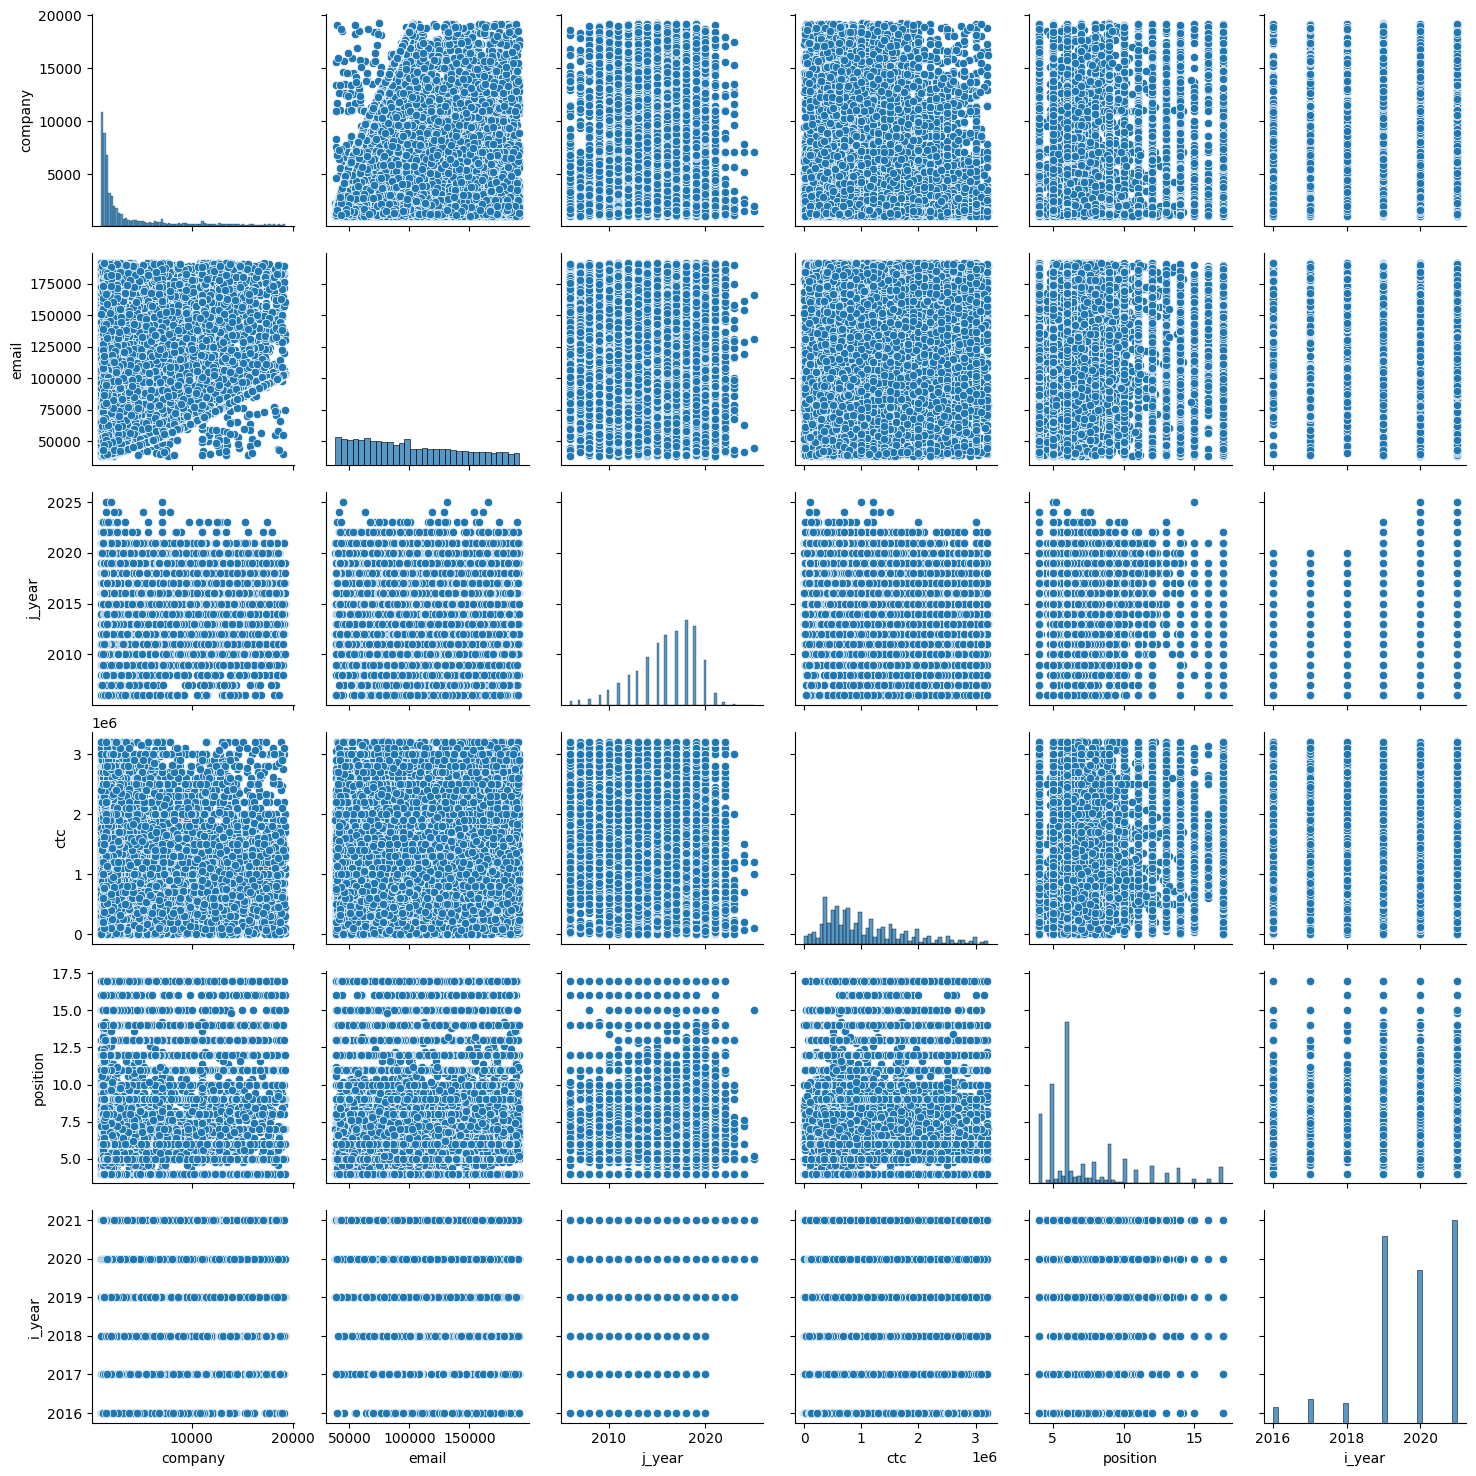

In [104]:
sns.pairplot(df_sampled)

In [105]:
df['position'].to_frame().value_counts()
#df['j_year'].head(10)

position
6.0         40933
5.0         24309
4.0         17141
9.0          9708
10.0         5887
            ...  
14.6            3
15.6            3
15.8            2
15.2            1
16.8            1
Length: 61, dtype: int64

In [106]:
df.head()
df = df_sampled

/usr/local/lib/python3.10/dist-packages/sklearn/cluster/_kmeans.py:870: FutureWarning:

The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning



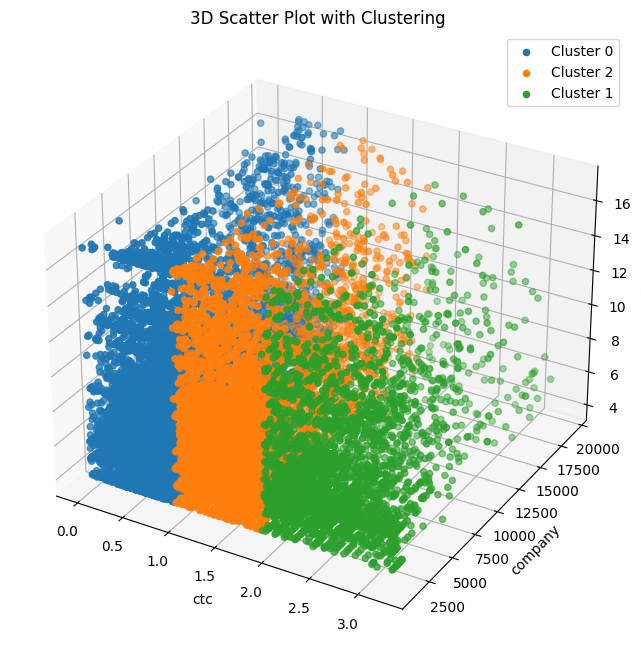

In [107]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D
from sklearn.cluster import KMeans

feature1 = 'ctc'
feature2 = 'company'
feature3 = 'position'

# Perform clustering (replace with your clustering logic)
X = df[[feature1, feature2, feature3]]
kmeans = KMeans(n_clusters=3, random_state=42)
df['cluster'] = kmeans.fit_predict(X)

# Plot 3D scatter plot with clusters as hue
fig = plt.figure(figsize=(10, 8))
ax = fig.add_subplot(111, projection='3d')

for cluster in df['cluster'].unique():
    cluster_df = df[df['cluster'] == cluster]
    ax.scatter(cluster_df[feature1], cluster_df[feature2], cluster_df[feature3], label=f'Cluster {cluster}')

ax.set_xlabel(feature1)
ax.set_ylabel(feature2)
ax.set_zlabel(feature3)
ax.set_title('3D Scatter Plot with Clustering')
ax.legend()
plt.show()

In [108]:
print(df.info(),df.describe)

<class 'pandas.core.frame.DataFrame'>
Int64Index: 25000 entries, 33008 to 113877
Data columns (total 7 columns):
 #   Column    Non-Null Count  Dtype  
---  ------    --------------  -----  
 0   company   25000 non-null  float64
 1   email     25000 non-null  float64
 2   j_year    25000 non-null  float64
 3   ctc       25000 non-null  float64
 4   position  25000 non-null  float64
 5   i_year    25000 non-null  float64
 6   cluster   25000 non-null  int32  
dtypes: float64(6), int32(1)
memory usage: 1.4 MB
None <bound method NDFrame.describe of         company     email  j_year        ctc  position  i_year  cluster
33008    2838.0   71045.0  2016.0   450000.0       6.0  2018.0        0
133087   6165.0  164267.0  2018.0  1280000.0       5.0  2019.0        2
56302    1543.0   66715.0  2008.0  2000000.0      11.0  2021.0        1
50977    1066.0   87840.0  2020.0   500000.0       6.0  2020.0        0
128433  11018.0  170721.0  2019.0   500000.0       9.8  2019.0        0
...         ...

/usr/local/lib/python3.10/dist-packages/sklearn/cluster/_kmeans.py:870: FutureWarning:

The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning



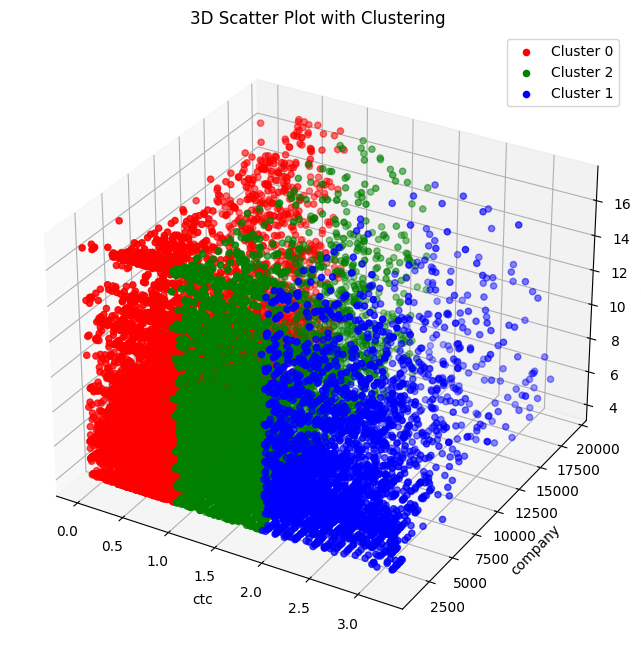

In [109]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D
from sklearn.cluster import KMeans

# Assuming your dataframe is named 'df'

# Define features for clustering
features = ['ctc', 'company', 'position']

# Perform clustering
X = df[features]
kmeans = KMeans(n_clusters=3, random_state=42)  # You can adjust the number of clusters
df['cluster'] = kmeans.fit_predict(X)

# Plot 3D scatter plot with clusters as hue
fig = plt.figure(figsize=(10, 8))
ax = fig.add_subplot(111, projection='3d')

# Define colors for each cluster
colors = ['r', 'g', 'b']

for cluster, color in zip(df['cluster'].unique(), colors):
    cluster_df = df[df['cluster'] == cluster]
    ax.scatter(cluster_df[features[0]], cluster_df[features[1]], cluster_df[features[2]], c=color, label=f'Cluster {cluster}')

ax.set_xlabel(features[0])
ax.set_ylabel(features[1])
ax.set_zlabel(features[2])
ax.set_title('3D Scatter Plot with Clustering')
ax.legend()
plt.show()

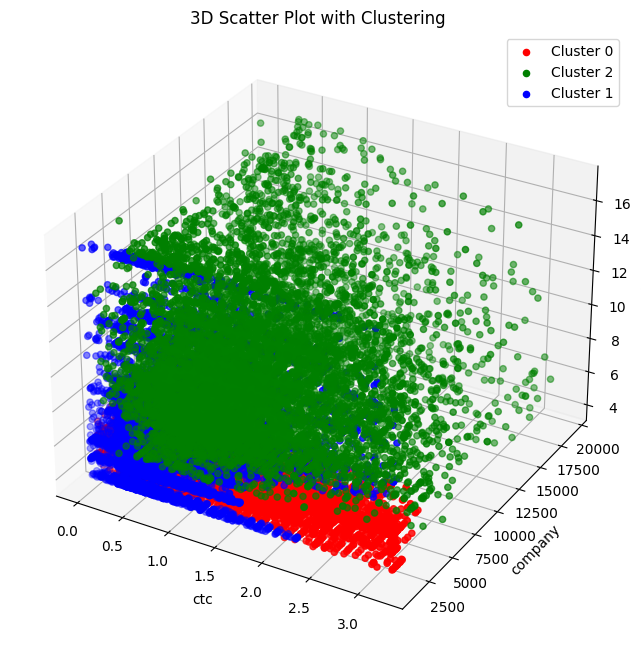

In [111]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D
from sklearn.mixture import GaussianMixture

# Assuming your dataframe is named 'df'

# Define features for clustering
features = ['ctc', 'company', 'position']

# Perform clustering with GMM
X = df[features]
gmm = GaussianMixture(n_components=3, covariance_type= 'diag',random_state=42)  # You can adjust the number of components (clusters)
df['cluster'] = gmm.fit_predict(X)

# Plot 3D scatter plot with clusters as hue
fig = plt.figure(figsize=(10, 8))
ax = fig.add_subplot(111, projection='3d')

# Define colors for each cluster
colors = ['r', 'g', 'b','y','c']

for cluster, color in zip(df['cluster'].unique(), colors):
    cluster_df = df[df['cluster'] == cluster]
    ax.scatter(cluster_df[features[0]], cluster_df[features[1]], cluster_df[features[2]], c=color, label=f'Cluster {cluster}')

ax.set_xlabel(features[0])
ax.set_ylabel(features[1])
ax.set_zlabel(features[2])
ax.set_title('3D Scatter Plot with Clustering')
ax.legend()
plt.show()